# Описание проекта
Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Инструкция по выполнению проекта
Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Это редкие случаи, которые легко пропустить, если всегда применять только бустинг. Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.
Проанализируйте скорость работы и качество моделей.

Примечания:
- Для оценки качества моделей применяйте метрику RMSE.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del:


# Описание данных

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак:
- Price — цена (евро)

Тайминг:

- %time – определяет время выполнения команды
- %timeit – определяет среднее время выполнения команды, многократно повторяя ее
- %%time – определяет время выполнения ячейки
- %%timeit – определяет среднее время выполнения ячейки

Профилирование:

- %prun – показывает как много времени подпрограмма тратит в каждой из функций
- %mprun – трэкинг использования памяти

# Содержание <a id='0.0'></a>

<a href='#1.1'>1. Подготовка данных'</a>

 - <a href='#1.2'>1.1 загрузка и предобработка данных'</a>
 - <a href='#1.3'>1.2 определение корреляции данных'</a>
 - <a href='#1.4'>1.3 Изучение распределение данных'</a>
 
<a href='#1.5'>2. Обучение моделей'</a>

 - <a href='#1.6'>2.1 Разделение выборки'</a>
 - <a href='#1.7'>2.2 Подбор наилучших параметров моделей'</a>

<a href='#1.8'>3. Анализ моделей'</a>

<a href='#1.9'>4. Выводы'</a>


# 1. Подготовка данных <a id='1.1'></a>

In [807]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp
import timeit
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder,OrdinalEncoder,OneHotEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings
warnings.filterwarnings("ignore")
# Импортируем необходимые библиотеки.

### 1.2 Загрузка и предобработка данных

In [613]:
autos = pd.read_csv('/datasets/autos.csv')
#autos = pd.read_csv('/Users/kazbek/Desktop/Python/Payton/DS - обучение/Новая папка 2/autos.csv')
display(autos.head())
display(autos.info())
display(pd.concat([autos.isna().sum(), autos.isna().sum()/len(autos)], axis=1).sort_values(by=[0],ascending=False).head())
display('Количество дубликатов - {}'.format(autos.duplicated().sum()))
# чтение файла. Просмотрим общий вид таблиц и инфу по файлу.

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,0,1
NotRepaired,71154,0.200791
VehicleType,37490,0.105794
FuelType,32895,0.092827
Gearbox,19833,0.055967
Model,19705,0.055606


'Колличество дубликатов - 4'

In [614]:
display(autos[(autos['Price'] == 0)&(autos['Gearbox'].isna())&(autos['VehicleType'].isna())&(autos['FuelType'].isna())].head(10))
# методом isnull посмотрел совпадения пропусков в столбцах 'gearbox' и 'model' VehicleType


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
154,2016-03-22 16:37:59,0,NaN,2006,NaN,0,other,5000,0,NaN,fiat,NaN,2016-03-22 00:00:00,0,44867,2016-04-06 06:17:56
415,2016-03-11 10:52:49,0,NaN,1985,NaN,0,3er,150000,0,NaN,bmw,NaN,2016-03-11 00:00:00,0,85051,2016-03-11 11:41:09
471,2016-04-04 02:37:41,0,NaN,1990,NaN,0,3er,5000,0,NaN,bmw,NaN,2016-04-04 00:00:00,0,59073,2016-04-06 09:16:42
522,2016-03-14 18:40:14,0,NaN,2000,NaN,0,NaN,150000,0,NaN,volvo,NaN,2016-03-14 00:00:00,0,25524,2016-03-14 18:40:14
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16 00:00:00,0,44628,2016-03-20 16:44:37
969,2016-03-25 09:57:23,0,NaN,1990,NaN,0,3er,150000,0,NaN,bmw,NaN,2016-03-25 00:00:00,0,66822,2016-03-29 22:46:53
1396,2016-04-05 10:58:11,0,NaN,2000,NaN,0,NaN,150000,0,NaN,volvo,NaN,2016-04-05 00:00:00,0,14552,2016-04-05 11:46:04
1672,2016-03-30 23:57:49,0,NaN,2000,NaN,0,fiesta,5000,0,NaN,ford,NaN,2016-03-30 00:00:00,0,88682,2016-03-31 07:45:24
2065,2016-03-07 15:06:23,0,NaN,2000,NaN,0,NaN,5000,0,NaN,sonstige_autos,NaN,2016-03-07 00:00:00,0,57610,2016-03-07 15:06:23
2301,2016-03-06 12:48:00,0,NaN,2016,NaN,105,3er,150000,0,NaN,bmw,NaN,2016-03-06 00:00:00,0,33415,2016-03-07 17:45:06


<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> Таблица с данными состоит из 354369 записей и 16 столбцов, и имеет два типа данных - object и int64. Название столбцов на латинице в верхнем регистре, без пробелов - можно перевести в нижний регистр для удобства работы. В данных имеются пропуски в столбцах NotRepaired (20% от всех данных), VehicleType (10% от всех данных), FuelType (9% от всех данных), Gearbox (6% от всех данных), Model (6% от всех данных). Все эти столбцы (признаки) - категориальные, и вероятно, важны для определения стоимости машины. При первом ознакомлении с данными видно,что есть не нужные нам столбцы, которые не влияют на формирование стоимости автомобиля. Например столбцы с датами, столбец с количеством фотографий и столбец с почтовым индексом - их можно удалить. так же у нас есть 4 дубликата,  которые мы смело удалим. Пропуски в этих признаках заполним значением other

In [615]:
autos.columns = [x.lower() for x in autos.columns]
# переводим в нижний регистр столбцы фрейма для удобства работы 
display(autos.columns)

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [616]:
autos = autos.drop(['numberofpictures', 'datecrawled', 'datecreated', 'lastseen','postalcode'], axis=1)
# удалим ненужные нам столбцы методом drop

##### Посмотрим как распределены наши категориальные столбцы - какие в них уникальные значения

In [617]:
display(autos['vehicletype'].value_counts())

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicletype, dtype: int64

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> Как видим у нас в столбце есть значение other, т.е. в столбце vehicletype у нас 37490 пропусков и 3288 - other,пропусков много и удалять их не стоит, пользователь мог просто не указать тип кузова авто. Можно заменить пропуски на значение other - обьеденить, так сказать.

In [618]:
display(autos['gearbox'].value_counts())

manual    268251
auto       66285
Name: gearbox, dtype: int64

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> В столбце gearbox у нас только два значения,но 19833 пропуска. С чем это связано - есть еще роботезированная коробка передач,вариаторная коробка передач и возможно пользователь не указа тип коробки передач из-за это. Можно заменить пропуски на значение other

In [619]:
display(autos['model'].value_counts())

golf                  29232
other                 24421
3er                   19761
polo                  13066
corsa                 12570
                      ...  
serie_2                   8
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: model, Length: 250, dtype: int64

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> В столбце model есть значение other, т.е. в столбце model у нас 19705 пропусков и 24421 - other,пропусков много и удалять их не стоит, пользователь мог просто не указать модель авто. Можно заменить пропуски на значение other - обьеденить.

In [620]:
display(autos['fueltype'].value_counts())

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: fueltype, dtype: int64

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> В столбце fueltype у нас аналогичная картина - есть значение other, т.е. в столбце fueltype у нас 32895 пропусков и 204 - other,пропусков много и удалять их не стоит. Возможно, пользователь просто не указа тип топлива. Можно заменить пропуски на значение other - обьеденить.

In [621]:
# Заменим пропуски на значение other
autos.fillna(value='other', inplace=True)

In [622]:
# удалим дубликаты методом drop_duplicates
autos = autos.drop_duplicates().reset_index(drop=True)

In [623]:
# Проверим на наличие пропусков
display(autos.isna().sum())

price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
dtype: int64

In [624]:
display(autos.head())

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
0,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,other
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


<a href='#0.0'>Содержание'</a>

### 1.2 Определение корреляции данных <a id='1.3'></a>

##### Посмотрим как коррелируют наши столбцы. для начала посмотрим на статистические показатели числовых признаков.

In [625]:
# Методом describe выводим статистические показатели числовых столбцов
autos.describe()

,price,registrationyear,power,kilometer,registrationmonth
count,326719.000000,326719.000000,326719.000000,326719.000000,326719.000000
mean,4404.326115,2004.232466,110.259308,128147.551872,5.696889
std,4518.369580,91.134742,195.912988,37942.468873,3.723788
min,0.000000,1000.000000,0.000000,5000.000000,0.000000
25%,1000.000000,1999.000000,69.000000,125000.000000,3.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000
75%,6350.000000,2008.000000,141.000000,150000.000000,9.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000


<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> Начнем с целевого признака price:
 - минимальное значение 0, а максимум 20000 евро - и это не нормально, стоимость машины 0 евро, нам ни как не поможет в определении стоимости и скорее всего машины не стоят меньше 100 евро - даже если продают авто на запчасти. 
 - среднее значение 4403 евро, а стандартное отклонение 4518, медиана 2700 - распределение не нормально,разброс огромный и очень много выбросов - нужно детально иследовать этот признак.
 
Признака registrationyear: 
 - минимальное значение 1000, а максимум 9999 год - и это не нормально,  явные выбросы. 
 - среднее значение 2004 год, а стандартное отклонение 91 год - разброс огромный - нужно детально иследовать этот признак.

Признака power: 
 - минимальное значение 0, а максимум 20000 л.с. - и это тоже не нормально, явные выбросы. 
 - среднее значение 110 л.с., а стандартное отклонение 195 л.с.

Признака kilometer: 
 - минимальное значение 5000, а максимум 150000 км. - нормально. 
 - среднее значение 128144 км., а стандартное отклонение 37947 км. - нужно детально иследовать этот признак.

Признака registrationmonth: 
 - думаю данный признак мало чем полезен нам для определения стоимости авто.

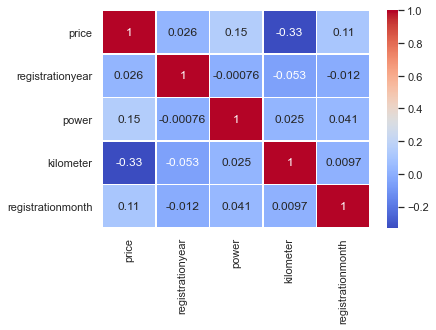

In [626]:
# Посмотрим на корреляцию числовых признаков
sns.heatmap(autos.corr(),annot=True,cmap='coolwarm',linewidths=0.5)
plt.show()

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> Есть небольшая отрицательная зависимость между столбцом kilometer и целевым признаком.Другие признаки не имеют явной связи с ценой автомобиля.

### 1.3 Изучение распределение данных <a id='1.4'></a>

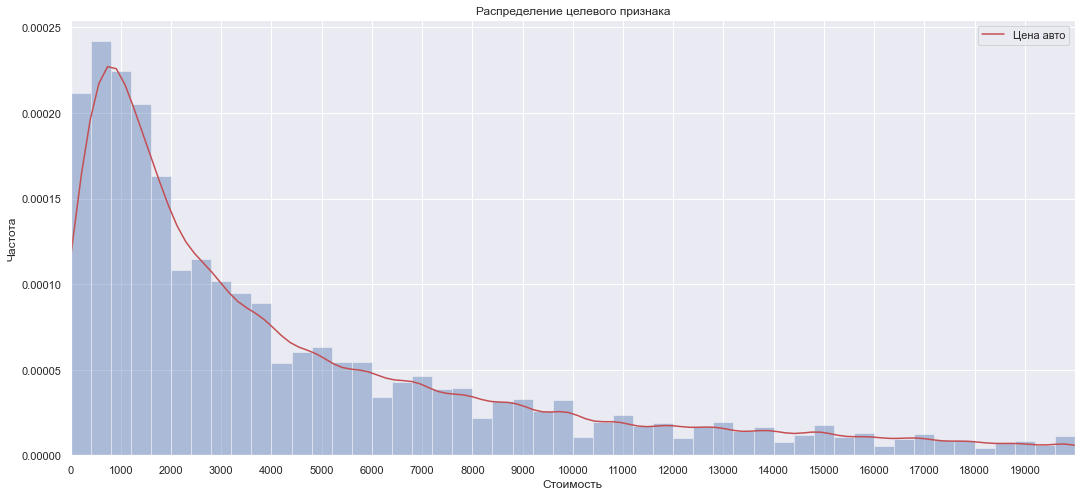

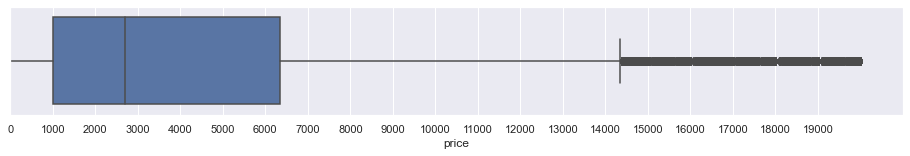

In [627]:
# Посмотрим на распределение целевого признака, построим графики
plt.subplots(figsize=(18,8))
sns.set(style="darkgrid")

ax = sns.distplot(autos['price'],
                  kde_kws={"color": "r", "label": "Цена авто"})                                                 
ax.set_xlabel('Стоимость')
ax.set_ylabel('Частота')
plt.title('Распределение целевого признака')
plt.xticks(np.arange(0,20000,step=1000))
plt.xlim(0, 20000)
plt.show()

plt.figure(figsize=(16,2))
plt.xticks(np.arange(0,20000,step=1000))
plt.xlim(-2, 21000)
sns.boxplot(x='price', data=autos)
plt.show()

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> Распределение имеет асиметричный вид - смещенно в право. С ростом стоимости снижается количествопредложений. 

In [628]:
# Количество  значений цены меньше 100
autos[autos['price']<=100].shape

(12728, 11)

In [629]:
# Изучим целевой признак - в нем очень много некоректных значений равных 0,1,2 евро и т.д. 
price = (autos
         .groupby('price')['registrationyear']
         .agg('count')
         .reset_index()
         .sort_values(by='price',ascending = True)
)
display(price[price['price'] <= 100].head())

,price,registrationyear
0,0,9351
1,1,1091
2,2,12
3,3,7
4,4,1


<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> В ходе изучения расспределения целевого признака пришли к следующему выводу, что значений меньше 100 евро в наших данных всего 12728, из них 9351 это нули и 1091 - единицы. Можно отбросить эти значения

In [630]:
# Количество  значений цены меньше 1980 года
display(autos[autos['registrationyear']<=1980].shape)
autos[autos['registrationyear']>=2020].shape

(3869, 11)

(100, 11)

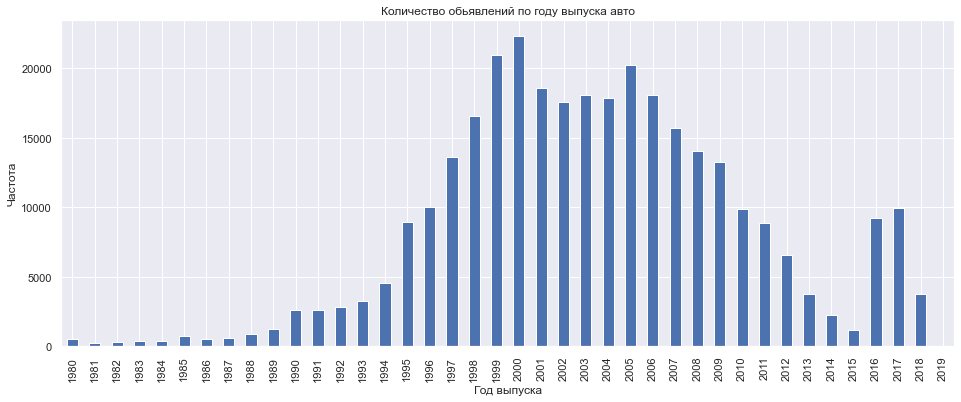

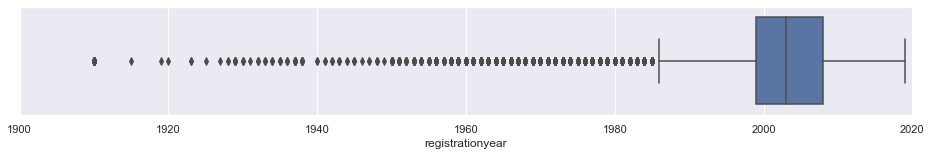

In [631]:
# Посмотрим на распределение признака registrationyear, построим графики
year = (autos
         .query('registrationyear >= 1980 and registrationyear <= 2020')
         .groupby('registrationyear')['registrationyear']
         .agg('count')
         .plot(y = 'count',kind='bar',figsize=(16, 6),grid=True,title = 'Количество обьявлений по году выпуска авто') 
         
) 
plt.ylabel('Частота')
plt.xlabel('Год выпуска')
plt.show()
plt.figure(figsize=(16,2))
plt.xlim(1900, 2020)
sns.boxplot(x='registrationyear', data=autos)
plt.show()

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> Распределение нормальное, есть выбросы меньше 1980 года - 3869, и больше 2020 года - 100. Можно отбросить выбросы

0      36991
75     22000
60     14497
150    13288
101    12249
Name: power, dtype: int64

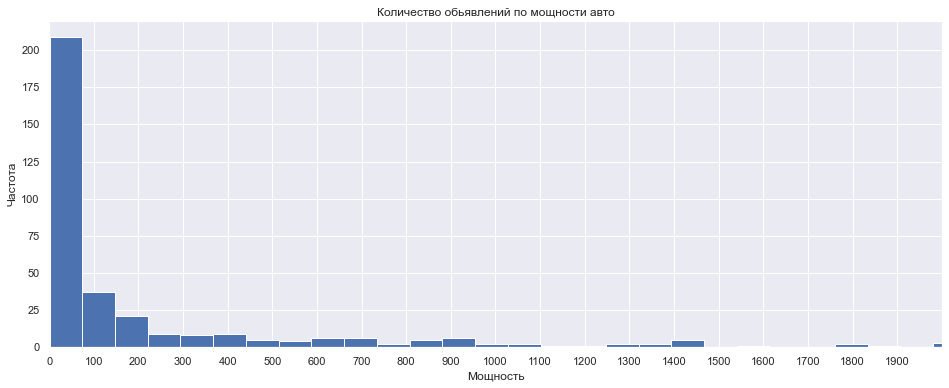

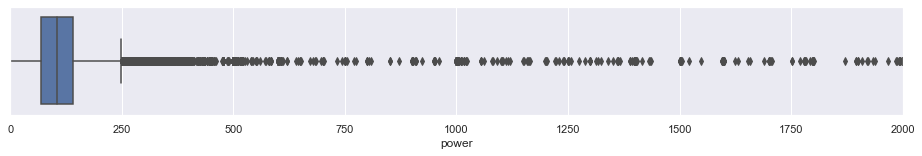

In [632]:
# Посмотрим на распределение признака power, построим графики
display(autos['power'].value_counts().head())
power = (autos
         .query('power >= 30 and power <= 500')
         .groupby('power')['power']
         .agg('count')
         .plot(kind='hist',bins=300,figsize=(16, 6),grid=True,title = 'Количество обьявлений по мощности авто') 
         
) 
plt.ylabel('Частота')
plt.xlabel('Мощность')
plt.xticks(np.arange(0,2000,step=100))
plt.xlim(0, 2000)
plt.show()

plt.figure(figsize=(16,2))
plt.xlim(-1, 2000)
sns.boxplot(x='power', data=autos)
plt.show()


In [633]:
# Количество  значений цены меньше 1980 года
display(autos[autos['power']<=30].shape)
autos[autos['power']>=600].shape

(37892, 11)

(387, 11)

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> Распределение не нормальное, положительно смещенное в право, асиметричное. Есть выбросы - значений меньше 30 л.с. в наших данных 37892, из них 36991 это нули, значений больше 600 л.с. - 387. Думаю авто с супер мощными моторами не так много, можно отбросить эти значения 

In [634]:
# Удалим все выше перечисленные выбросы методом query и удалим не влияющий на стоимость столбец с месяцем регистрации.
good_autos = autos.drop(['registrationmonth'], axis=1)
good_autos = autos.query('registrationyear <= 2020 and registrationyear >= 1980 and power <= 600 and power >= 30 and price >100')

In [635]:
display(good_autos.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278649 entries, 1 to 326718
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              278649 non-null  int64 
 1   vehicletype        278649 non-null  object
 2   registrationyear   278649 non-null  int64 
 3   gearbox            278649 non-null  object
 4   power              278649 non-null  int64 
 5   model              278649 non-null  object
 6   kilometer          278649 non-null  int64 
 7   registrationmonth  278649 non-null  int64 
 8   fueltype           278649 non-null  object
 9   brand              278649 non-null  object
 10  notrepaired        278649 non-null  object
dtypes: int64(5), object(6)
memory usage: 25.5+ MB


None

In [637]:
display(good_autos.isna().sum())
display(good_autos.head())
display('Количество дубликатов - {}'.format(good_autos.duplicated().sum()))

price                0
vehicletype          0
registrationyear     0
gearbox              0
power                0
model                0
kilometer            0
registrationmonth    0
fueltype             0
brand                0
notrepaired          0
dtype: int64

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired
1,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,other
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes


'Колличество дубликатов - 0'

In [655]:

display(f'Количество потерь данных:{(len(autos) - len(good_autos))}')
display(f'Процент потерь данных:{(len(autos) - len(good_autos))/len(autos)*100}')

'Количество потерь данных:48070'

'Количество потерь данных:14.712949047958643'

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> После проведения предобработки данных у нас осталось 278649 значений и 10 столбцов.Потеря данных составила 48070 или 14.71 %

<a href='#0.0'>Содержание'</a>

# 2. Обучение моделей <a id='1.5'></a>

### 2.1 Разделение выборки  <a id='1.6'></a>

In [656]:
# Сохраним значение random_state в переменной rs
rs=12345

In [657]:
# Разделим нашу таблицу с данными на целевой признак и осальные признаки
features = good_autos.drop(['price'], axis = 1)
target = good_autos['price']

In [658]:
# преобразуем строки категориальных признаков в числовые при помощи OneHotEncoder, произведем кодирование данных
features_ohe = pd.get_dummies(features, drop_first=True)
# Для работы с моделью LightGBM необходимо указать, какие переменные являются категориальными. LightGBM понимает тип int
categorial = ['vehicletype', 'gearbox', 'model', 'fueltype','notrepaired','registrationmonth','brand']
for col in categorial:
    features[col] = features[col].astype('category')

In [659]:
# Разделим выборку на обучающую и тестовую часть - для модели LGBM отдельно и для остальных моделей.
features_train_LGBM, features_test_LGBM, target_train_LGBM, target_test_LGBM = train_test_split(features,
                                                                                                target, 
                                                                                                test_size=.25,
                                                                                                random_state=rs)
features_train, features_test, target_train, target_test = train_test_split(features_ohe,
                                                                            target, test_size=.25,random_state=rs)

In [660]:
# Провеем стандартизацию данных методом StandardScaler
# Создадим объект этой структуры и настроим его на обучающих данных.
numeric = ['registrationyear','power','kilometer',]
scaler = StandardScaler()
scaler.fit(features_train[numeric])
# Преобразуем обучающую и тестовую выборки функцией transform
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [852]:
# проверяем с помощью вывода метода shape количество записей и столбцов в выборках
display(features_train.shape,features_test.shape)
display(features_train_LGBM.shape,features_test_LGBM.shape)
display(target_train.shape)
display(target_test.shape)

(208986, 307)

(69663, 307)

(208986, 10)

(69663, 10)

(208986,)

(69663,)

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> В ходе разделения наших данных на выборки (обучающая выборка - 75% и тестовая - 25%) мы получили два набора выборок отдельно для модели LGBM и для остальных моделей. Количество записей в признаках для модели LGBM составило 208986 и столбцов 10, а для признаков остальных моделей 208986 и 307 столбцов. Выборки с целевыми признаками составили 69663 записей. Так же была проведена кодировка данных с помощью метода OneHotEncoder для всех моделей, кроме модели LGBM, для нее мы изменили тип данных категориальных признаков. так же провели стандартизацию данных методом StandardScaler.

### 2.2 Подбор наилучших параметров моделей  <a id='1.7'></a>

In [663]:
# Создадим функцию для определения метрики RMSE для оценки моделей
def rmse(target, pred):
    return (mean_squared_error(target, pred)**0.5)
rmse_score = make_scorer(rmse, greater_is_better=True)

In [804]:
# Создадим функцию для пременения способа GridSearchCV для нахождения и сохранения лучших параметров модели
def best_parameters(Regressor,features,target,param):
    model = GridSearchCV(estimator=Regressor, param_grid=param, cv=3,n_jobs=-1)
    model.fit(features, target)
    display(f'Лучшие параметры: {model.best_params_}')
    return model.best_estimator_

In [788]:
# Запишем параметры,которые мы хотим перебрать для разных моделей в отдельные переменные 
param_tree = {'max_depth': range(1, 10),
          'min_samples_split': range(2, 40, 10), 
          'min_samples_leaf': range(1, 20, 5)}
param_forest = {'n_estimators': range(10, 50, 10),
                'max_depth': range(3,10,3),
                'min_samples_leaf':range(2,6,2)}
param_linear = {}
param_LGBM = {'max_depth': range(2,11,2),
              'num_leaves':range(10,70,10),
              'learning_rate':[0.1,0.2]}
param_catboost = {'depth': range(2,11,2),
                  'learning_rate':[0.1,0.2],
                  'iterations':[80]}

In [855]:
# Создадим Константную модель для проверки на адекватность. Предсказывать будем по среднему тренировочной выборки.
dummy = DummyRegressor(strategy='mean')
start_time = timeit.default_timer()
dummy.fit(features_train, target_train)
educ_time_dummy = round(timeit.default_timer() - start_time,5)
pred_dummy = dummy.predict(features_train)
pred_time_dummy = round(timeit.default_timer() - start_time - educ_time_dummy,5)
result_dummy = rmse(target_train, pred_dummy)
display(f'Время обучения: {educ_time_dummy}')
display(f'Время предсказания: {pred_time_dummy}')
display(f'Метрики качества модели RMSE: {result_dummy}')

'Время обучения: 0.00074'

'Время предсказания: 0.001'

'Метрики качества модели RMSE: 4574.095332999386'

In [805]:
display('Модель DecisionTreeRegressor:')
tree_model = best_parameters(DecisionTreeRegressor(random_state=rs),features_train,target_train,param_tree)
pred = tree_model.predict(features_train)
display(f'Метрики качества модели RMSE:{rmse(target_train, pred)}')

'Модель DecisionTreeRegressor:'

"Лучшие параметры: {'max_depth': 9, 'min_samples_leaf': 6, 'min_samples_split': 32}"

'Метрики качества модели RMSE:1947.712488180004'

In [820]:
display('Модель RandomForestRegressor:')
forest_model = best_parameters(RandomForestRegressor(random_state=rs),features_train,target_train,param_forest)
pred = forest_model.predict(features_train)
display(f'Метрики качества модели RMSE:{rmse(target_train, pred)}')

'Модель RandomForestRegressor:'

"Лучшие параметры: {'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 40}"

'Метрики качества модели RMSE:1879.5755032338752'

In [822]:
display('Модель CatBoostRegressor:')
catboost_model = best_parameters(CatBoostRegressor(loss_function = 'RMSE',random_state = rs,verbose = False),
                                 features_train,target_train,param_catboost)
pred = catboost_model.predict(features_train)
display(f'Метрики качества модели RMSE:{rmse(target_train, pred)}')

'Модель CatBoostRegressor:'

"Лучшие параметры: {'depth': 10, 'iterations': 80, 'learning_rate': 0.2}"

'Метрики качества модели RMSE:1578.8280852936819'

In [824]:
display('Модель LinearRegression:')
linear_model = best_parameters(LinearRegression(),features_train,target_train,param_linear)
pred = linear_model.predict(features_train)
display(f'Метрики качества модели RMSE:{rmse(target_train, pred)}')

'Модель LinearRegression:'

'Лучшие параметры: {}'

'Метрики качества модели RMSE:2436.612192733538'

In [826]:
display('Модель LGBMRegressor:')
LGBM_model = best_parameters(LGBMRegressor(random_state=rs),features_train_LGBM,target_train,param_LGBM)
pred = LGBM_model.predict(features_train_LGBM)
display(f'Метрики качества модели RMSE:{rmse(target_train, pred)}')

'Модель LGBMRegressor:'

"Лучшие параметры: {'learning_rate': 0.2, 'max_depth': 10, 'num_leaves': 60}"

'Метрики качества модели RMSE:1416.609721498856'

<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'> В ходе подбора параметров для моделей проделали следующее:

- Создали функцию для преминения способа GridSearchCV для нахождения и сохранения лучших параметров модели
- В качестве метрики качества использовали RMSE
- Создали константную модель для проверки на адекватность с помощью DummyRegressor - использовали среднее значение. Время обучения составило 0.0007 сек., время предсказания - 0.00126 сек., а метрика качества модели RMSE: 4574.10 евро.
- В исследовании применяли 5 моделей: Решающего дерева, Случайного леса, Линейной регрессии, CatBoostRegressor и LGBMRegressor
- Метрика качества RMSE для модели Решающего дерева на обучающей выборке составила 1947.71 евро.
- Метрика качества RMSE для модели Случайного леса на обучающей выборке составила 1879.57 евро.
- Метрика качества RMSE для модели Линейной регрессии на обучающей выборке составила 2436.61 евро.
- Метрика качества RMSE для модели CatBoostRegressor на обучающей выборке составила 1578.82 евро.
- Метрика качества RMSE для модели LGBMRegressor на обучающей выборке составила 1416.60 евро.


<a href='#0.0'>Содержание'</a>

# 3. Анализ моделей <a id='1.8'></a>

In [801]:
# Создадим функцию для нахождения и сохранения метрики качества на тестовой выборке и определения времени обучения и предсказания
def time(model,f_train,f_test,t_train,t_test):
    start_time = timeit.default_timer()
    model=model
    model.fit(f_train, t_train)
    educ_time = round(timeit.default_timer() - start_time, 2)
    pred = model.predict(f_test)
    pred_time = round(timeit.default_timer() - start_time - educ_time, 2)
    result = rmse(t_test, pred)
    return educ_time,pred_time,result
def time_disp(educ_time,pred_time,result):
    display(f'Время обучения: {educ_time}')
    display(f'Время предсказания: {pred_time}')
    display(f'Метрики качества модели RMSE: {result}')

In [819]:
display('Модель DecisionTreeRegressor на тестовой выборке :')
educ_time_tree,pred_time_tree,result_tree = time(tree_model,features_train,features_test,target_train,target_test)
time_disp(educ_time_tree,pred_time_tree,result_tree)

'Модель DecisionTreeRegressor на тестовой выборке :'

'Время обучения: 4.47'

'Время предсказания: 0.16'

'Метрики качества модели RMSE: 1991.1267846701955'

In [821]:
display('Модель RandomForestRegressor на тестовой выборке:')
educ_time_forest,pred_time_forest,result_forest = time(forest_model,features_train,features_test,
                                                       target_train,target_test)
time_disp(educ_time_forest,pred_time_forest,result_forest)

'Модель RandomForestRegressor на тестовой выборке:'

'Время обучения: 100.21'

'Время предсказания: 0.37'

'Метрики качества модели RMSE: 1925.2305545791812'

In [823]:
display('Модель CatBoostRegressor на тестовой выборке:')
educ_time_catboost,pred_time_catboost,result_catboost = time(catboost_model,features_train,features_test,
                                                             target_train,target_test)
time_disp(educ_time_catboost,pred_time_catboost,result_catboost)

'Модель CatBoostRegressor на тестовой выборке:'

'Время обучения: 2.74'

'Время предсказания: 0.03'

'Метрики качества модели RMSE: 1622.052116721818'

In [825]:
display('Модель LinearRegression на тестовой выборке:')
educ_time_ln,pred_time_ln,result_ln = time(linear_model,features_train,features_test,target_train,target_test)
time_disp(educ_time_ln,pred_time_ln,result_ln)

'Модель LinearRegression на тестовой выборке:'

'Время обучения: 2.54'

'Время предсказания: 0.12'

'Метрики качества модели RMSE: 2441.4246861978368'

In [827]:
display('Модель LGBMRegressor на тестовой выборке:')
educ_time_LGBM,pred_time_LGBM,result_LGBM = time(LGBM_model,features_train_LGBM,features_test_LGBM,
                                                 target_train,target_test)
time_disp(educ_time_LGBM,pred_time_LGBM,result_LGBM)

'Модель LGBMRegressor на тестовой выборке:'

'Время обучения: 0.83'

'Время предсказания: 0.15'

'Метрики качества модели RMSE: 1554.2445985438098'

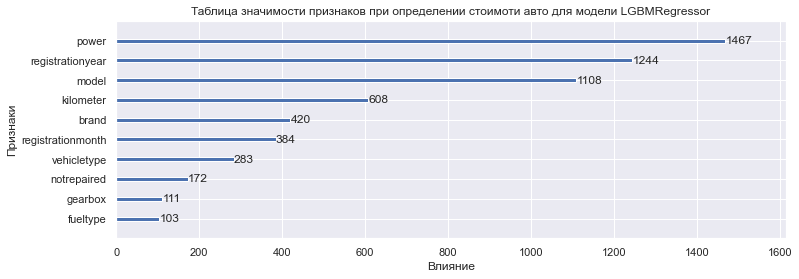

In [850]:
lgb.plot_importance(LGBM_model,figsize=(12,4),
                    title = 'Таблица значимости признаков при определении стоимоти авто для модели LGBMRegressor')
plt.ylabel('Признаки')
plt.xlabel('Влияние')
plt.show()

In [857]:
result_all = pd.DataFrame(
    {'Использованые модели регрессии': ['Dummy','DecisionTree','RandomForest','Catboost','Linear','LGBM'],
     'Время обучения':[educ_time_dummy,educ_time_tree,educ_time_forest,educ_time_catboost,educ_time_ln,educ_time_LGBM],
     'Время предсказания':[pred_time_dummy,pred_time_tree,pred_time_forest,pred_time_catboost,pred_time_ln,pred_time_LGBM],
     'Лучшая метрика RMSE':[result_dummy,result_tree,result_forest, result_catboost, result_ln,result_LGBM]}
)
result_all.sort_values(by='Лучшая метрика RMSE',ascending = True)

,Использованые модели регрессии,Время обучения,Время предсказания,Лучшая метрика RMSE
5,LGBM,0.83000,0.150,1554.244599
3,Catboost,2.74000,0.030,1622.052117
2,RandomForest,100.21000,0.370,1925.230555
1,DecisionTree,4.47000,0.160,1991.126785
4,Linear,2.54000,0.120,2441.424686
0,Dummy,0.00074,0.001,4574.095333


<div style="border:solid blue 2px; padding: 20px">
    
<font color='blue'>  В ходе анализа моделей проделали следующее:

- Создали функцию для определения метрики качества RMSE для тестовой выборки и определения времени обучения модели и времени предсказания
- В качестве определения времени использовали метод timeit
- Для модели LGBMRegressor вывели таблица значимости признаков при определении стоимоти авто.
- Сформировали сводную таблицу с результатами исследования.

<a href='#0.0'>Содержание'</a>

# Выводы <a id='1.9'></a>

### Лучший результат показала модель LightGBMRegressor (RMSE 1554.24, время обучения 0.83000, а время предсказания 0.150), второй результат у модели CatBoostRegressor (RMSE 1622.05, время обучения 2.74000, а время предсказания 0.030). Третье место принадлежит Случайному лесу. Все модели адекватные: они справляются лучше, чем предсказание среднего значения целевого признака. Как обычно с увеличением сложности модели растет качество, но уменьшается скорость. Так же для нашей лучшей модели LightGBMRegressor значимыми признаками для определения стоимости авто являются мощность, год регистрации авто и модель авто


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей

<a href='#0.0'>Содержание'</a>